# DPD simulation of diblock copolymer

**`By You-Liang Zhu`**

## Introduction

This tutorial provides an introduction of DPD simulations of diblock copolymer. It is suitable for new users who want to learn about how to run DPD simulations. It does however assume that you have a machine with GALAMOST correctly installed.

In this tutorial, we would like to make a system consisting of diblock copolymers to study the phase separation.

**Download [running files](https://bitbucket.org/galamostdevelopergroup/source-code/src/master/examples/Case1-DPD-Phase-Seperation-of-Diblock-Copolymer/system/A5B5/)**.

In order to run this DPD simulation with GALAMOST, two files should be prepared:
*  `xml`: file that describes all the information (including position, velocity, topology, etc.) of the particles. More about [XML data format](https://galamost.readthedocs.io/en/latest/data-format.html). The xml configuration file could be generated by [`Molgen`](https://galamost.readthedocs.io/en/latest/molgen.html) plugin
*  `gala`: file that describes the settings for the GALAMOST simulation engine.

## Prepare XML file

A system containing A5B5 diblock copolymer molecules need to be built for simulation.
In order to build the system, a python script of [`Molgen`](https://galamost.readthedocs.io/en/latest/molgen.html) that will call the [`Molgen`](https://galamost.readthedocs.io/en/latest/molgen.html) plugin of GALAMOST is needed.
The coarse-grained model of diblock copolymer is given: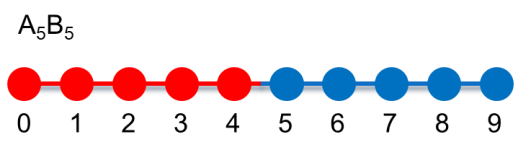

The [`Molgen`](https://galamost.readthedocs.io/en/latest/molgen.html) script "A5B5.molg" for randomly generating A5B5 diclock copolymers is given:

In [ ]:
mol1=molgen.Molecule(10) #particle number
mol1.setParticleTypes("A,A,A,A,A,B,B,B,B,B") #type
mol1.setTopology("0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9") #topology
mol1.setBondLength(0.75) #bond length
mol1.setMass(1.0) #mass

gen=molgen.Generators(20, 20, 20) #box size in x, y, and z direction
gen.addMolecule(mol1, 2400) #molecule, the number of molecules
gen.outPutXml("A5B5")  #file name

## Prepare GALA input file

What the simulation need next is the GALA file "A5B5-dpd.gala" that define the program settings for DPD run. 

In [ ]:
#!/usr/bin/python
import sys
sys.path.append('/opt/galamost3/lib') # the path where the GALAMOST program is installed
import galamost
from optparse import OptionParser
 
global _options
parser = OptionParser()
parser.add_option('--gpu', dest='gpu',help='GPU on which to execute')
(_options, args) = parser.parse_args()
 
filename = 'A5B5.xml' # initial configuration file
randomnum = 12340
build_method = galamost.XmlReader(filename)
perform_config = galamost.PerformConfig(_options.gpu) # assign GPU by index
all_info = galamost.AllInfo(build_method, perform_config) # build system information
 
dt = 0.04
app = galamost.Application(all_info, dt)  # build up an application with system information and integration time-step

neighbor_list = galamost.NeighborList(all_info, 1.0 ,0.05)#(,rcut,rbuffer)
dpd = galamost.DpdForce(all_info, neighbor_list, 1.0, randomnum)#(,,rcut, the seed for RNG)
dpd.setParams('A', 'A', 25.0, 3.0)#(type,type,alpha,sigma)
dpd.setParams('A', 'B', 40.0, 3.0)#(type,type,alpha,sigma)
dpd.setParams('B', 'B', 25.0, 3.0)#(type,type,alpha,sigma)
app.add(dpd)
 
bondforce = galamost.BondForceHarmonic(all_info) # bond stretching interaction by harmonic potential
bondforce.setParams('A-A', 4.0, 0.0)#(bond type, K0-spring constant, R0-equilibrium distance)
bondforce.setParams('A-B', 4.0, 0.0)#(bond type ,K0-spring constant, R0-equilibrium distance)
bondforce.setParams('B-B', 4.0, 0.0)#(bond type ,K0-spring constant, R0-equilibrium distance)
app.add(bondforce)

group = galamost.ParticleSet(all_info, "all") # a collection of particles
comp_info = galamost.ComputeInfo(all_info, group)  # calculating system informations, such as temperature, pressure, and momentum

Gwvv = galamost.DpdGwvv(all_info, group) # integration method with GWVV algorithm
app.add(Gwvv)

sort_method = galamost.Sort(all_info)  # memory sorting to improve performance 
sort_method.setPeriod(80)
app.add(sort_method) 

DInfo = galamost.DumpInfo(all_info, comp_info, 'data.log') # output system informations, such as temperature, pressure, and momentum
DInfo.setPeriod(200)
app.add(DInfo)
 
mol2 = galamost.Mol2Dump(all_info, 'particles') # output the configuration files in mol2 format
mol2.setPeriod(0)# (period)
mol2.deleteBoundaryBond(True)# (period)
app.add(mol2)
 
dcd = galamost.DcdDump(all_info, 'particles',True) # output the configuration files in DCD format
dcd.setPeriod(10000)# (period)
dcd.unwrap(True)
app.add(dcd)
 
xml = galamost.XmlDump(all_info, 'particles') # output the configuration files in xml format
xml.setPeriod(50000)# (period)
xml.setOutputBond(True)
app.add(xml)

#ready ro run
app.run(500000)#(the number of steps to run)
neighbor_list.printStats() # output the information about neighbor_list 

[OVITO](http://www.ovito.org/) is suggested to render the pictures of system snapshots with the output XML files